<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/gym_atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep-Q-Network (DQN) Learning on Breakout

In this notebook, we will be training a simple Deep Q Network reinforcement learning model to play Breakout game using the OpenAI GYM game simulator.

Breakout is an ideal game for DQN for several reason


*   Breakout is deterministic. Given the state of the game (location and velocity of the ball), an optimal decision exists and it is not (that) stochastic. DQN, by its definition, aims to find a deterministic Q function given state and action. Thus DQN is ideal for games like Breakout.
*   The action space is, TINY. In fact, only left or right. This helps us to construct DQN in a very simple way: input is a vector of game state, and output is the Q value at each action.

To make it simpler and easier to train, we will do a little bit cheating here. Instead of observing the frame, we will be using the "RAM" information of the game as the state, which can be dumpped into a 128 by 1 vector. We will be using "breakout-ramDeterministic-v4" environment of GYM.



function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}

setInterval(ClickConnect,60000)

In [0]:
!apt install xvfb -y
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 2s (346 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torchsummary import summary as pytorch_summary
%matplotlib inline

In [0]:
from matplotlib import animation, rc
from IPython.display import HTML
import IPython

is_ipython = 'inline' in matplotlib.get_backend()

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is {}'.format(device))

device is cuda


### Mount Google Drive to save model weights (Optional)
It is time consuming to train reinforcement learning, even for such a simple game. Colab only gives us 12 hr of usage. Although it is enough for Breakout, we still want to save the model weight somewhere eles in case we want to do a hot restart. The simplest solution is to mount your google drive and save the model weight there. It is completely optional.

In [0]:
#Load the Drive helper and mount
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if (not os.path.isdir('/content/drive/My Drive/Breakout_models/')):
    os.mkdir('/content/drive/My Drive/Breakout_models/')

### Set up parameter

In [0]:
# BATCH_SIZE = 128
# GAMMA = 0.99
# EPS_START = 0.9
# EPS_END = 0.1
# EPS_DECAY = 100000
# TARGET_UPDATE = 1000 #every {} steps, update target model

# model_save_freq = 200 #every {} episodes, save the model

# lr = 0.00025
# momentum = 0.95
# alpha = 0.95
# eps = 0.01

# replay_size = 200000
# replay_start_size = 10000

# nums_episodes = 5000

# skip_frame = 4

In [0]:
#env_name = 'Breakout-ramDeterministic-v4'
#env_name = 'BreakoutDeterministic-v4'
env_name = 'Breakout-ramNoFrameskip-v4'
#env_name = 'PongNoFrameskip-v4'

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.1
EPS_DECAY = 10**5
TARGET_UPDATE = 10000 #every {} steps, update target model

model_save_freq = 200 #every {} episodes, save the model

lr = 0.00005
momentum = 0.95
alpha = 0.95
eps = 0.01

replay_size = 10**5 * 4
replay_start_size = 0

skip_frame = 4

nums_episodes = 5000

In [0]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Take action on reset for environments that are fixed until firing."""
        super(FireResetEnv, self).__init__(env)
        print(env.unwrapped.get_action_meanings())
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.mean(np.stack(self._obs_buffer), axis=0)
        if total_reward>0:
            total_reward = 1.0
        elif total_reward<0:
            total_reward = -1.0
        else:
            total_reward = 0.0

        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

In [0]:
#create environment
env = gym.make(env_name)
env = MaxAndSkipEnv(env, skip = skip_frame)
env = FireResetEnv(env)

frame = env.reset()
# Render
#env.render()

print('Original state size = {}'.format(frame.shape))

['NOOP', 'FIRE', 'RIGHT', 'LEFT']
Original state size = (128,)


In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Model Definition

In [0]:
# class DQN_Atari(nn.Module):
    
#     def __init__(self, input_space, action_space):
#         super(DQN_Atari, self).__init__()
        
#         self.linear0 = nn.Linear(input_space, 128)
#         self.linear1 = nn.Linear(128, 128)
#         self.linear2 = nn.Linear(128, 128)
#         self.linear3 = nn.Linear(128, 128)
#         self.linear4 = nn.Linear(128, action_space)
#         self.dropout1 = nn.Dropout(p=0.5)
#         self.dropout2 = nn.Dropout(p=0.5)
#         self.dropout3 = nn.Dropout(p=0.5)
#         self.dropout4 = nn.Dropout(p=0.5)
        
        
#     def forward(self, x):
#         x = torch.relu(self.dropout1(self.linear0(x)))
#         x = torch.relu(self.dropout2(self.linear1(x)))
#         x = torch.relu(self.dropout3(self.linear2(x)))
#         x = torch.relu(self.dropout3(self.linear3(x)))
#         x = self.linear4(x)
#         return x

In [0]:
class DQN_Atari(nn.Module):
    
    def __init__(self, input_space, action_space):
        super(DQN_Atari, self).__init__()
        
        self.linear0 = nn.Linear(input_space, 64)
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(16, action_space)
        
        
    def forward(self, x):
        x = torch.relu(self.linear0(x))
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [0]:
pytorch_summary(DQN_Atari(128, 4).to(device), input_size=(128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           8,256
            Linear-2                   [-1, 32]           2,080
            Linear-3                   [-1, 16]             528
            Linear-4                    [-1, 4]              68
Total params: 10,932
Trainable params: 10,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


## Training

### hyperparameters and utilities

In [0]:
# Get number of actions from gym action space
n_actions = env.action_space.n
input_space = frame.shape[0]
policy_net = DQN_Atari(input_space, n_actions).to(device)
target_net = DQN_Atari(input_space, n_actions).to(device)

#policy_net.apply(init_weights)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

memory = ReplayMemory(replay_size)

In [0]:
steps_done = 0
episodes_reward = []
episodes_duration = []

In [0]:
#target_net.load_state_dict(torch.load('/content/drive/My Drive/Breakout_models/target_net_model'))
#policy_net.load_state_dict(torch.load('/content/drive/My Drive/Breakout_models/target_net_model'))
#r, episode_durations =pickle.load(open('/content/drive/My Drive/Breakout_models/outputs.p','rb'))

In [0]:
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
#optimizer = optim.RMSprop(policy_net.parameters(), lr = lr, momentum = momentum, alpha = alpha, eps = eps)

In [0]:
def select_action(state, random_sample = False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold and not random_sample:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [0]:
def select_action_playing(state):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)

In [0]:
def plot_durations(y, fig_num = 2):
    if is_ipython:
      IPython.display.clear_output(wait=True)
      IPython.display.display(plt.gcf())
        
    plt.figure(fig_num,figsize=(15,8))
    plt.clf()
    y_t = torch.tensor(y, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(y_t.numpy())
    # plot moving average of recent 50 episode
    if len(y_t) >= 50:
        means = y_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())
    plt.text(0,0,steps_done)
    plt.show()

## Training Loop

In [0]:
# batch = Transition(*zip(*memory.sample(10)))
# batch


In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
    #                                      batch.next_state)), device=device, dtype=torch.bool)
    #non_final_next_states = torch.cat([s for s in batch.next_state
    #                                            if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    done_batch = batch.done
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    #next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    next_state_values = target_net(next_state_batch).max(1)[0]
    next_state_values[done_batch] = 0.0
    next_state_values = next_state_values.detach()
    
    # Compute the expected Q values
    expected_state_action_values = next_state_values * GAMMA + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

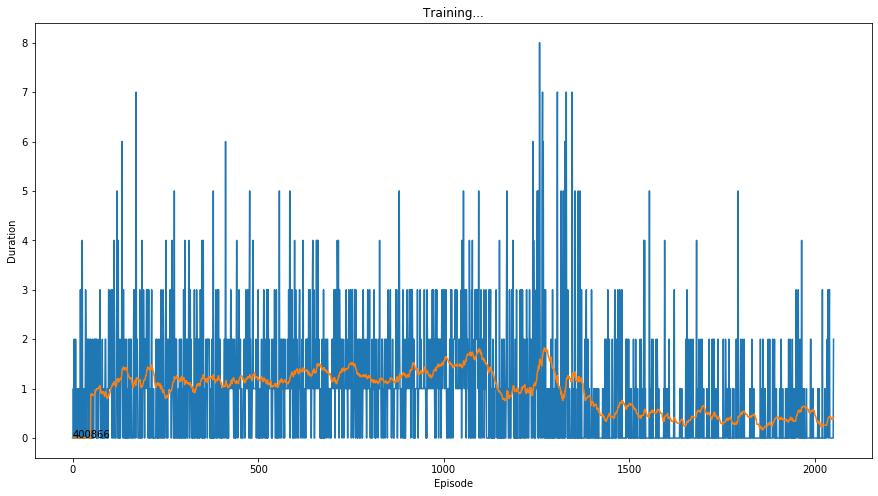

KeyboardInterrupt: ignored

In [0]:
policy_net.train()
nums_episodes
for i_episode in range(nums_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.FloatTensor(state/255.0).unsqueeze(0).to(device)
    episode_reword = 0
    for t in count():
        # Select and perform an action
        # if steps_done<replay_start_size:
        #     action = select_action(state, random_sample = True)
        # else:
        action = select_action(state)

        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.FloatTensor(next_state/255.0).unsqueeze(0).to(device)

        episode_reword += reward
        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        if steps_done>replay_start_size:
            for tmp in range(3):
                optimize_model()
        
        if done:
            episodes_reward.append(episode_reword)
            episodes_duration.append(t)
            
            if i_episode%10==0:
                plot_durations(episodes_reward, fig_num=2)
                #plot_durations(episodes_duration, fig_num=3)                
            break
        
    # Update the target network, copying all weights and biases in DQN
    if i_episode % model_save_freq == 0:
        if (os.path.isdir('/content/drive/My Drive/Breakout_models/')):
            print('saving model to GDrive')
            torch.save(target_net.state_dict(), '/content/drive/My Drive/Breakout_models/target_net_model')
            pickle.dump([episodes_duration,episodes_reward],open('/content/drive/My Drive/Breakout_models/outputs.p','wb'))
    if steps_done % TARGET_UPDATE ==0:
        target_net.load_state_dict(policy_net.state_dict())


print('Complete')

Text(0.5, 1.0, 'Moving average of per episodes reward')

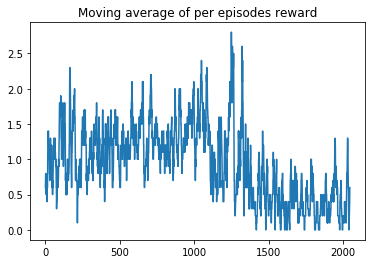

In [0]:
#plot moving average of game reward
w = 10
plt.plot(np.convolve(np.array(episodes_reward), np.ones(w), 'valid') / w)
plt.title('Moving average of per episodes reward')

Text(0.5, 1.0, 'Moving average of per step reward')

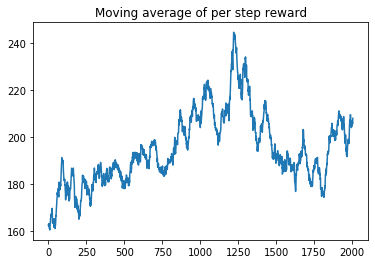

In [0]:
#plot moving average of game reward
w = 50
plt.plot(np.convolve(np.array(episodes_duration), np.ones(w), 'valid') / w)
#plt.plot(episodes_duration)
plt.title('Moving average of per step reward')

## Play

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '600x400x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '600x400x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=20)
    rc('animation', html='jshtml')
    return anim

311


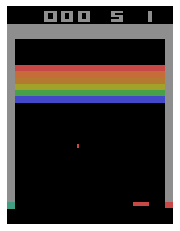

In [0]:
# Run a demo of the environment
a_list = []
policy_net.eval()
ob = env.reset()
cum_reward = 0
frames = []
current_state = torch.tensor([ob/255.0], dtype = torch.float32, device = device)
for t in range(500):
    # Render into buffer. 
    #action = env.action_space.sample()
    #ob, reward, done, info = env.step(action)
    action = select_action(current_state)
    #action = select_action(current_state, random_sample=True)
    action = action.item()
    ob, reward, done, info = env.step(action)
    a_list.append(action)
    frames.append(env.render(mode = 'rgb_array'))    
    current_state = torch.tensor([ob/255.0], dtype = torch.float32, device = device)
    if done:
        break
print(t)
anim = display_frames_as_gif(frames);

(array([ 54.,   0.,   0.,  66.,   0.,   0., 151.,   0.,   0.,  41.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

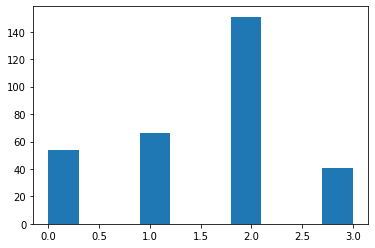

In [0]:
plt.hist(a_list)

In [0]:
anim

In [0]:
env.close()